# Line ratio grids
Produce and plot grids of line ratios for a variety of complex star formation histories.

## Imports

In [10]:
import numpy as np
import h5py
rng = np.random.default_rng()
import astropy.units as u
from astropy.table import Table
from corner import corner
import matplotlib.pyplot as plt
plt.style.use('ebm-dejavu')
%matplotlib inline

from lightning import Lightning
from lightning.priors import UniformPrior, NormalPrior
from lightning.plots import step_curve
from lightning.sfh import DelayedExponentialSFH

## Setup

Create two Lightning objects, loading the Cloudy grids with and without dust grains for BPASS stellar population models.

In [3]:
filter_labels = ['SDSS_u'] # We aren't actually using these, 'None' just isn't an option

agebins = [0.0] + list(np.logspace(7, np.log10(13.4e9), 10))

lgh_nodust = Lightning(filter_labels,
                       lum_dist=15, # also isn't going to come up
                       ages=agebins,
                       nebula_lognH=2.0,
                       nebula_dust=False,
                       stellar_type='BPASS-A24',
                       SFH_type='Piecewise-Constant',
                       atten_type='Modified-Calzetti',
                       print_setup_time=True)
print()
lgh_dust = Lightning(filter_labels,
                     lum_dist=15,
                     ages=agebins,
                     nebula_lognH=2.0,
                     nebula_dust=True,
                     stellar_type='BPASS-A24',
                     SFH_type='Piecewise-Constant',
                     atten_type='Modified-Calzetti',
                     print_setup_time=True)
                       

0.003 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
1.821 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.000 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.824 s elapsed total

0.001 s elapsed in _get_filters
0.000 s elapsed in _get_wave_obs
1.749 s elapsed in stellar model setup
0.000 s elapsed in dust attenuation model setup
0.000 s elapsed in dust emission model setup
0.000 s elapsed in agn emission model setup
0.000 s elapsed in X-ray model setup
1.750 s elapsed total


## Define SFH templates

For simplicity we'll convolve a delayed exponential SFH with the age bins.

Text(0, 0.5, '${\\rm SFR}(t)~[\\rm M_{\\odot}~yr^{-1}]$')

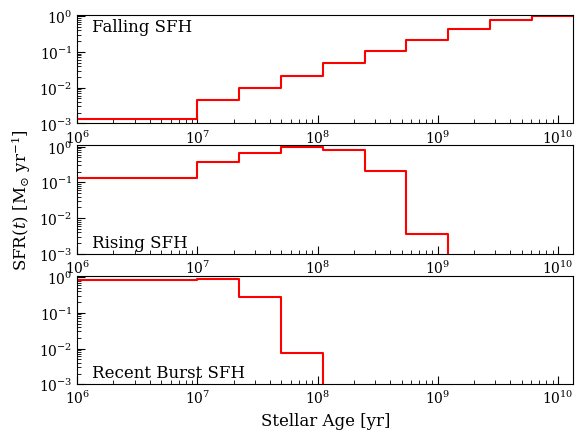

In [61]:
agemid = 0.5 * np.array(agebins[:-1]) + 0.5 * np.array(agebins[1:])
sfh_exp = DelayedExponentialSFH(agemid)


falling_sfh =  sfh_exp.evaluate(np.array([np.exp(1), 1e10]))
rising_sfh = sfh_exp.evaluate(np.array([np.exp(1), 1e8]))
recent_sfh = sfh_exp.evaluate(np.array([np.exp(1), 1e7]))

fig, axs = plt.subplots(3,1)

x,y = step_curve(agebins, falling_sfh)
axs[0].plot(x,y, color='red')

# x,y = step_curve(agebins, rising_sfh)
# axs[1].plot(x,y)
x,y = step_curve(agebins, rising_sfh)
axs[1].plot(x,y, color='red')

# x,y = step_curve(agebins, recent_sfh)
# axs[2].plot(x,y)
x,y = step_curve(agebins, recent_sfh)
axs[2].plot(x,y, color='red')

for i in [0,1,2]:
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim(1e6, 13.4e9)
    axs[i].set_ylim(1e-3, 1.1)

axs[0].text(0.03, 0.97, 'Falling SFH', ha='left', va='top', transform=axs[0].transAxes)
axs[1].text(0.03, 0.03, 'Rising SFH', ha='left', va='bottom', transform=axs[1].transAxes)
axs[2].text(0.03, 0.03, 'Recent Burst SFH', ha='left', va='bottom', transform=axs[2].transAxes)


axs[2].set_xlabel('Stellar Age [yr]')
axs[1].set_ylabel(r'${\rm SFR}(t)~[\rm M_{\odot}~yr^{-1}]$')

And now we'll derive grids of line ratios for our various faked SFHs:

## Dusty grid

Text(0.03, 0.97, 'Cloudy grid w/ dust')

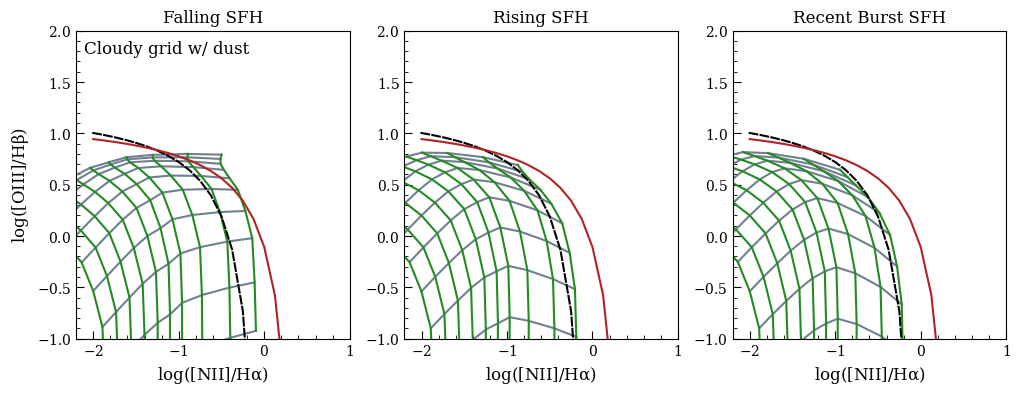

In [57]:
from python_snippets import k06_NIIplot

Npoints = 10

logU_grid = np.linspace(-4, -1.5, Npoints)
Z_grid = np.logspace(np.log10(0.00075), np.log10(0.02), Npoints)

tauV_grid = np.array([0.0])

fig, axs = plt.subplots(1,3, figsize=(12,4))

linestyle=['-','--']

OIIImask = lgh_dust.stars.line_labels == 'O__3_500684A'
Halphamask = lgh_dust.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh_dust.stars.line_labels == 'H__1_486132A'
NIImask = lgh_dust.stars.line_labels == 'N__2_658345A'

for m,sfh in enumerate([falling_sfh, rising_sfh, recent_sfh]):
    for k,tauV in enumerate(tauV_grid):

        param_array = np.zeros(15)
        param_array[:10] = sfh
        param_array[-3] = tauV

        line_grid = np.zeros((Npoints,Npoints,len(lgh_dust.stars.line_labels)))
        
        for i,logU in enumerate(logU_grid):
            for j,Z in enumerate(Z_grid):

                param_array[10] = Z
                param_array[11] = logU

                lines_ext, lines_intr = lgh_dust.get_model_lines(param_array)
                
                line_grid[i,j,:] = lines_ext.flatten()

        o3hbeta_grid = np.log10(line_grid[:,:,OIIImask] / line_grid[:,:,Hbetamask])
        n2halpha_grid = np.log10(line_grid[:,:,NIImask] / line_grid[:,:,Halphamask])

        for i,_ in enumerate(logU_grid):
            axs[m].plot(n2halpha_grid[i,:], o3hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
        
        for j,_ in enumerate(Z_grid):
            axs[m].plot(n2halpha_grid[:,j], o3hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])

        k06_NIIplot(ax=axs[m])
        axs[m].set_xlim(-2.2,1)
        axs[m].set_ylim(-1,2)

axs[0].set_title('Falling SFH')
axs[1].set_title('Rising SFH')
axs[2].set_title('Recent Burst SFH')

axs[0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
for m in [0,1,2]:
    axs[m].set_xlabel(r'$\rm \log([N II] / H\alpha)$')

axs[0].text(0.03, 0.97, 'Cloudy grid w/ dust', ha='left', va='top', transform=axs[0].transAxes)

## Grid without dust

Text(0.03, 0.97, 'Cloudy grid w/o dust')

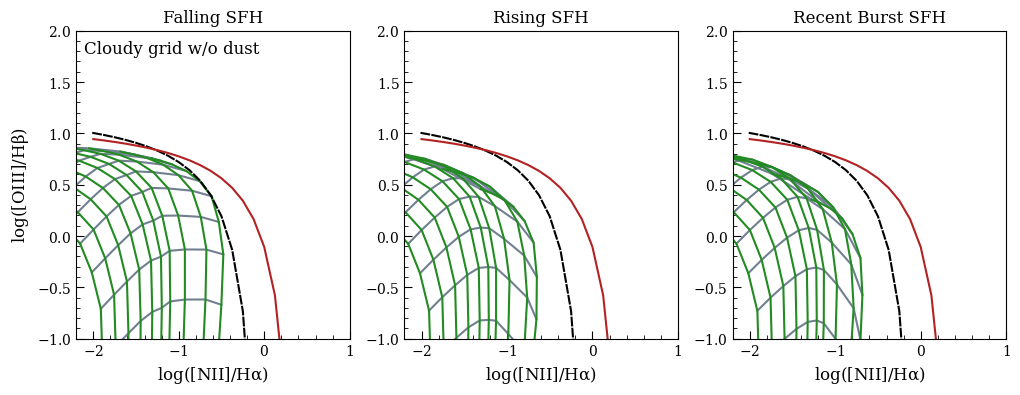

In [58]:
from python_snippets import k06_NIIplot

Npoints = 10

logU_grid = np.linspace(-4, -1.5, Npoints)
Z_grid = np.logspace(np.log10(0.00075), np.log10(0.02), Npoints)

tauV_grid = np.array([0.0])

fig, axs = plt.subplots(1,3, figsize=(12,4))

linestyle=['-','--']

OIIImask = lgh_nodust.stars.line_labels == 'O__3_500684A'
Halphamask = lgh_nodust.stars.line_labels == 'H__1_656280A'
Hbetamask = lgh_nodust.stars.line_labels == 'H__1_486132A'
NIImask = lgh_nodust.stars.line_labels == 'N__2_658345A'

for m,sfh in enumerate([falling_sfh, rising_sfh, recent_sfh]):
    for k,tauV in enumerate(tauV_grid):

        param_array = np.zeros(15)
        param_array[:10] = sfh
        param_array[-3] = tauV

        line_grid = np.zeros((Npoints,Npoints,len(lgh_nodust.stars.line_labels)))
        
        for i,logU in enumerate(logU_grid):
            for j,Z in enumerate(Z_grid):

                param_array[10] = Z
                param_array[11] = logU

                lines_ext, lines_intr = lgh_nodust.get_model_lines(param_array)
                
                line_grid[i,j,:] = lines_ext.flatten()

        o3hbeta_grid = np.log10(line_grid[:,:,OIIImask] / line_grid[:,:,Hbetamask])
        n2halpha_grid = np.log10(line_grid[:,:,NIImask] / line_grid[:,:,Halphamask])

        for i,_ in enumerate(logU_grid):
            axs[m].plot(n2halpha_grid[i,:], o3hbeta_grid[i,:], color='slategray', linestyle=linestyle[k])
        
        for j,_ in enumerate(Z_grid):
            axs[m].plot(n2halpha_grid[:,j], o3hbeta_grid[:,j], color='forestgreen', linestyle=linestyle[k])

        k06_NIIplot(ax=axs[m])
        axs[m].set_xlim(-2.2,1)
        axs[m].set_ylim(-1,2)

axs[0].set_title('Falling SFH')
axs[1].set_title('Rising SFH')
axs[2].set_title('Recent Burst SFH')

axs[0].set_ylabel(r'$\rm \log([O III] / H\beta)$')
for m in [0,1,2]:
    axs[m].set_xlabel(r'$\rm \log([N II] / H\alpha)$')

axs[0].text(0.03, 0.97, 'Cloudy grid w/o dust', ha='left', va='top', transform=axs[0].transAxes)